In [1]:
%matplotlib inline

#System
import os
import shutil

#Base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
from skimage.io import imread, imshow, imsave

#Keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPool2D, UpSampling2D
from keras.layers import Dropout,BatchNormalization, Concatenate
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint

#Preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence, to_categorical

#Models
from keras.applications.vgg16 import VGG16

#GPU
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto() 
config.gpu_options.allow_growth = True
sess = tf.Session(config=config) 
K.set_session(sess)

#Seed
seed = 99
np.random.seed(seed)
random.seed(seed)

Using TensorFlow backend.
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/fra

## Генераторы данных

In [2]:
img_shape = 256
batch_size = 4
num_classes = 32

train_size = len(os.listdir(path="data/ADE20K_formated/train/img/img/"))
val_size = len(os.listdir(path="data/ADE20K_formated/val/img/img/"))

train_dir = "data/ADE20K_formated/train/"
val_dir = "data/ADE20K_formated/val/"

img_train_dir = train_dir + "img/img/"
mask_train_dir = train_dir + "mask/mask/"

img_val_dir = val_dir + "img/img/"
mask_val_dir = val_dir + "mask/mask/"

In [3]:
def dice_coef(y_true, y_pred, smooth=0.01):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [4]:
def data_gen(img_dir, mask_dir, num_classes, batch_size):
    img_folder = img_dir
    mask_folder = mask_dir
    num_classes = num_classes
    
    img_list = os.listdir(img_folder)
    random.shuffle(img_list)
    img_dir_size = len(img_list)
    
    for i in range(len(img_list)):
        img_list[i] = img_list[i].split(".")[0] #отделяем имя от формата
        
    c = 0
    while (True):
        img = np.zeros((batch_size, img_shape, img_shape, 3)).astype('float')
        mask = np.zeros((batch_size, img_shape, img_shape, num_classes)).astype("uint8")

        for i in range(c, c + batch_size):  

            train_img = cv2.imread(img_folder + '/' + img_list[i] + ".jpg") / 255.
            train_img =  cv2.resize(train_img, (img_shape, img_shape))

            img[i - c] = train_img 

            train_mask = cv2.imread(mask_folder + '/' + img_list[i] + ".png", cv2.IMREAD_GRAYSCALE)
            train_mask = cv2.resize(train_mask, (img_shape, img_shape), interpolation = cv2.INTER_NEAREST)
            train_mask = train_mask.reshape(img_shape, img_shape, 1)
            train_mask = to_categorical(train_mask, num_classes=num_classes)
            
            mask[i - c] = train_mask

        c += batch_size
        
        if (c + batch_size >= img_dir_size):
            c = 0
            random.shuffle(img_list)
                  
        yield img, mask
        
train_gen = data_gen(img_train_dir,mask_train_dir, num_classes=num_classes, batch_size=batch_size)
val_gen = data_gen(img_val_dir,mask_val_dir, num_classes=num_classes, batch_size=batch_size)

In [5]:
def get_model(img_shape, num_classes):
    block0_input = Input(shape=(img_shape, img_shape, 3))

    block1_conv1 = Conv2D(64, (3, 3), padding="same", activation="relu")(block0_input)
    block1_conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(block1_conv1)
    block1_conv3 = Conv2D(64, (3, 3), padding="same", activation="relu")(block1_conv2)
    block1_pool1 = MaxPool2D(2)(block1_conv3)

    block2_conv1 = Conv2D(128, (3, 3), padding="same", activation="relu")(block1_pool1)
    block2_conv2 = Conv2D(128, (3, 3), padding="same", activation="relu")(block2_conv1)
    block2_conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(block2_conv2)
    block2_pool1 = MaxPool2D(2)(block2_conv3)

    block3_conv1 = Conv2D(256, (3, 3), padding="same", activation="relu")(block2_pool1)
    block3_conv2 = Conv2D(256, (3, 3), padding="same", activation="relu")(block3_conv1)
    block3_conv3 = Conv2D(256, (3, 3), padding="same", activation="relu")(block3_conv2)
    block3_pool1 = MaxPool2D(2)(block3_conv3)

    block4_conv1 = Conv2D(512, (3, 3), padding="same", activation="relu")(block3_pool1)
    block4_conv2 = Conv2D(512, (3, 3), padding="same", activation="relu")(block4_conv1)
    block4_pool1 = MaxPool2D(2)(block4_conv2)
    
    block5_conv1 = Conv2D(1024, (3, 3), padding="same", activation="relu")(block4_pool1)
    block5_upsa1 = UpSampling2D(2, interpolation="bilinear")(block5_conv1)
    
    block6_conc1 = Concatenate()([block4_conv2, block5_upsa1])
    block6_conv1 = Conv2D(512, (3, 3), padding="same", activation="relu")(block6_conc1)
    block6_conv2 = Conv2D(512, (3, 3), padding="same", activation="relu")(block6_conv1)
    block6_upsa1 = UpSampling2D(2, interpolation="bilinear")(block6_conv2)

    block7_conc1 = Concatenate()([block3_conv3, block6_upsa1])
    block7_conv1 = Conv2D(256, (3, 3), padding="same", activation="relu")(block7_conc1)
    block7_conv2 = Conv2D(256, (3, 3), padding="same", activation="relu")(block7_conv1)
    block7_conv3 = Conv2D(256, (3, 3), padding="same", activation="relu")(block7_conv2)
    block7_upsa1 = UpSampling2D(2, interpolation="bilinear")(block7_conv3)

    block8_conc1 = Concatenate()([block2_conv3, block7_upsa1])
    block8_conv1 = Conv2D(128, (3, 3), padding="same", activation="relu")(block8_conc1)
    block8_conv2 = Conv2D(128, (3, 3), padding="same", activation="relu")(block8_conv1)
    block8_conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(block8_conv2)
    block8_upsa1 = UpSampling2D(2, interpolation="bilinear")(block8_conv3)

    block9_conc1 = Concatenate()([block1_conv3, block8_upsa1])
    block9_conv1 = Conv2D(64, (3, 3), padding="same", activation="relu")(block9_conc1)
    block9_conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(block9_conv1)
    block9_conv3 = Conv2D(64, (3, 3), padding="same", activation="relu")(block9_conv2)
    
    block10_output = Conv2D(num_classes, (1, 1), padding="same", activation="softmax")(block9_conv3)

    return Model(inputs=block0_input, outputs=block10_output)

model = get_model(None, num_classes)

In [6]:
def get_callbacks(dir_name):
    best_w = ModelCheckpoint("checkpoints/" + dir_name + "/best_w.h5", 
                             monitor="val_loss",
                             verbose=0,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='auto',
                             period=1
                            )

    last_w = ModelCheckpoint("checkpoints/" + dir_name + "/last_w.h5",
                             monitor="val_loss",
                             verbose=0,
                             save_best_only=False,
                             save_weights_only=True,
                             mode='auto',
                             period=1
                            )

    callbacks = [best_w, last_w]
    return callbacks

In [7]:
history = []

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/100
250/250 [==============================] - 289s 1s/step - loss: 1.5310 - accuracy: 0.6997 - dice_coef: 0.4872 - val_loss: 1.4057 - val_accuracy: 0.7119 - val_dice_coef: 0.4522
Epoch 2/100
250/250 [==============================] - 272s 1s/step - loss: 1.4212 - accuracy: 0.7056 - dice_coef: 0.5082 - val_loss: 1.6206 - val_accuracy: 0.7130 - val_dice_coef: 0.4932
Epoch 3/100
250/250 [==============================] - 276s 1s/step - loss: 1.4505 - accuracy: 0.6967 - dice_coef: 0.4989 - val_loss: 1.2922 - val_accuracy: 0.7118 - val_dice_coef: 0.4452
Epoch 4/100
250/250 [==============================] - 272s 1s/step - loss: 1.3918 - accuracy: 0.7115 - dice_coef: 0.5176 - val_loss: 1.1016 - val_accuracy: 0.7127 - val_dice_coef: 0.5696
Epoch 5/100
250/250 [==============================] - 279s 1s/step - loss: 1.3599 - accuracy: 0.7173 - dice_coef: 0.5302 - val_loss: 0.7720 - val_accura

250/250 [==============================] - 276s 1s/step - loss: 1.2436 - accuracy: 0.7089 - dice_coef: 0.5430 - val_loss: 1.4782 - val_accuracy: 0.7109 - val_dice_coef: 0.5504
Epoch 42/100
250/250 [==============================] - 278s 1s/step - loss: 1.2467 - accuracy: 0.7070 - dice_coef: 0.5407 - val_loss: 2.4472 - val_accuracy: 0.7137 - val_dice_coef: 0.5333
Epoch 43/100
250/250 [==============================] - 274s 1s/step - loss: 1.2404 - accuracy: 0.7068 - dice_coef: 0.5422 - val_loss: 1.2192 - val_accuracy: 0.7187 - val_dice_coef: 0.5615
Epoch 44/100
250/250 [==============================] - 274s 1s/step - loss: 1.2268 - accuracy: 0.7098 - dice_coef: 0.5471 - val_loss: 1.1290 - val_accuracy: 0.7104 - val_dice_coef: 0.5378
Epoch 45/100
250/250 [==============================] - 275s 1s/step - loss: 1.2230 - accuracy: 0.7079 - dice_coef: 0.5456 - val_loss: 0.9776 - val_accuracy: 0.7178 - val_dice_coef: 0.5511
Epoch 46/100
250/250 [==============================] - 276s 1s/step

250/250 [==============================] - 277s 1s/step - loss: 1.1827 - accuracy: 0.7095 - dice_coef: 0.5558 - val_loss: 1.1258 - val_accuracy: 0.7273 - val_dice_coef: 0.5576
Epoch 85/100
250/250 [==============================] - 276s 1s/step - loss: 1.1719 - accuracy: 0.7104 - dice_coef: 0.5598 - val_loss: 1.3630 - val_accuracy: 0.7067 - val_dice_coef: 0.5515
Epoch 86/100
250/250 [==============================] - 275s 1s/step - loss: 1.1551 - accuracy: 0.7142 - dice_coef: 0.5636 - val_loss: 1.0622 - val_accuracy: 0.7194 - val_dice_coef: 0.5459
Epoch 87/100
250/250 [==============================] - 276s 1s/step - loss: 1.1630 - accuracy: 0.7118 - dice_coef: 0.5601 - val_loss: 1.5269 - val_accuracy: 0.7223 - val_dice_coef: 0.5529
Epoch 88/100
250/250 [==============================] - 277s 1s/step - loss: 1.1505 - accuracy: 0.7165 - dice_coef: 0.5668 - val_loss: 1.0040 - val_accuracy: 0.7097 - val_dice_coef: 0.5747
Epoch 89/100
250/250 [==============================] - 276s 1s/step

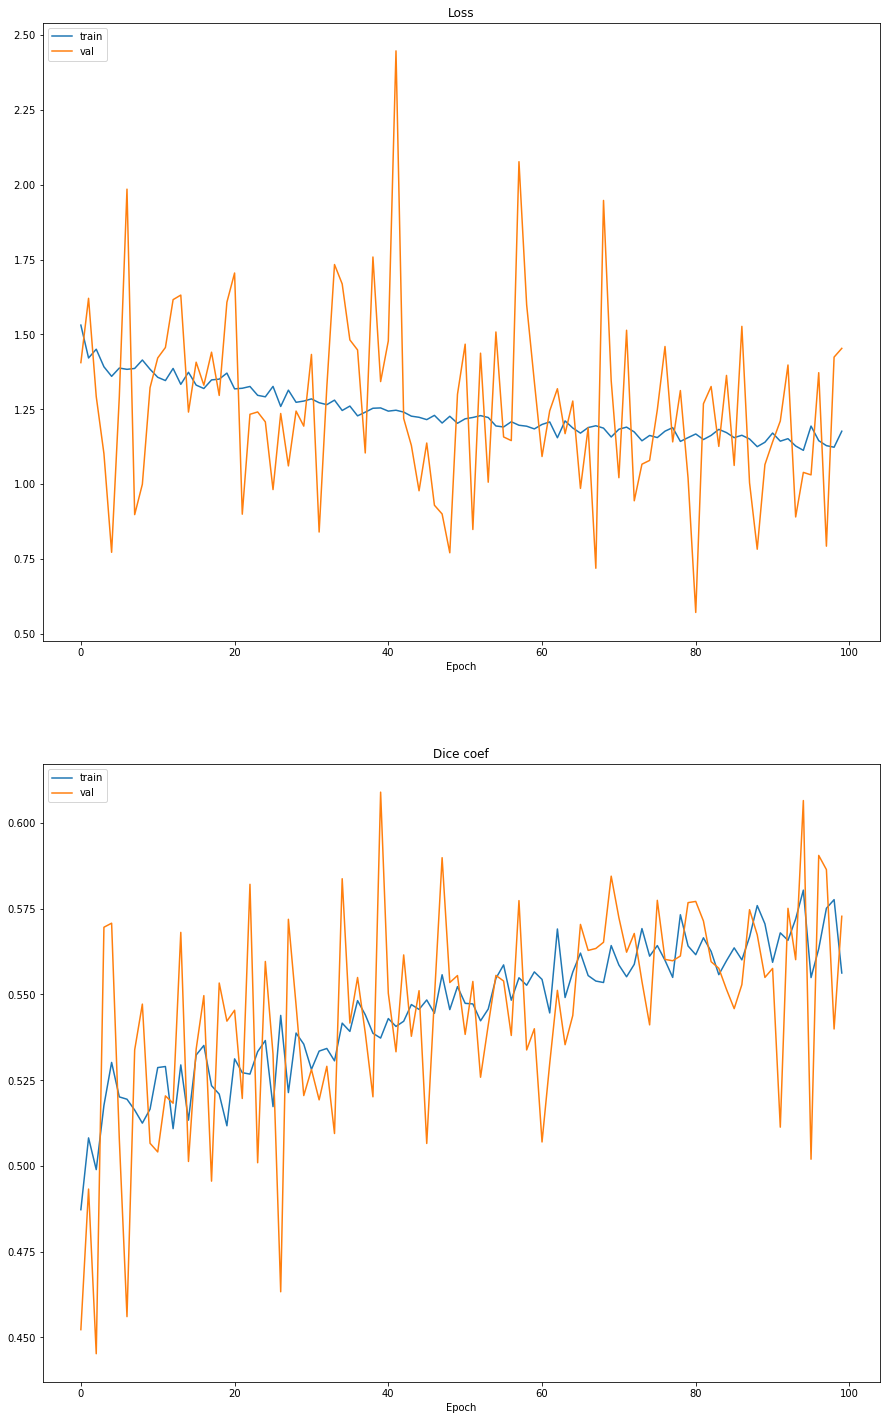

CPU times: user 5h 23min 3s, sys: 1h 14min 51s, total: 6h 37min 55s
Wall time: 7h 45min 39s


In [8]:
%%time
    
model.compile(Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=["accuracy", dice_coef])
    
model.fit_generator(train_gen, 
                      epochs=100,
                      steps_per_epoch=250,
                      validation_data=val_gen, 
                      validation_steps=val_size//batch_size,
                      verbose=1,
                      callbacks=get_callbacks("w1")
                     )

history.append(model.history.history)

plt.figure(figsize=(15, 25))
plt.subplot(211)
plt.title("Loss")
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.xlabel("Epoch")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(212)
plt.title("Dice coef")
plt.plot(model.history.history['dice_coef'])
plt.plot(model.history.history['val_dice_coef'])
plt.xlabel("Epoch")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
%%time
    
model.compile(Adam(learning_rate=0.0005), 
              loss='categorical_crossentropy', 
              metrics=["accuracy", dice_coef])
    
model.fit_generator(train_gen, 
                      epochs=100,
                      steps_per_epoch=250,
                      validation_data=val_gen, 
                      validation_steps=val_size//batch_size,
                      verbose=1,
                      callbacks=get_callbacks("w2")
                     )

history.append(model.history.history)

plt.figure(figsize=(15, 25))
plt.subplot(211)
plt.title("Loss")
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.xlabel("Epoch")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(212)
plt.title("Dice coef")
plt.plot(model.history.history['dice_coef'])
plt.plot(model.history.history['val_dice_coef'])
plt.xlabel("Epoch")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Epoch 1/100
250/250 [==============================] - 280s 1s/step - loss: 1.1161 - accuracy: 0.7168 - dice_coef: 0.5732 - val_loss: 0.7399 - val_accuracy: 0.7215 - val_dice_coef: 0.5650
Epoch 2/100
250/250 [==============================] - 276s 1s/step - loss: 1.0870 - accuracy: 0.7229 - dice_coef: 0.5820 - val_loss: 1.1017 - val_accuracy: 0.7144 - val_dice_coef: 0.5854
Epoch 3/100
250/250 [==============================] - 276s 1s/step - loss: 1.1164 - accuracy: 0.7186 - dice_coef: 0.5761 - val_loss: 0.9903 - val_accuracy: 0.7150 - val_dice_coef: 0.5658
Epoch 4/100
250/250 [==============================] - 276s 1s/step - loss: 1.1233 - accuracy: 0.7189 - dice_coef: 0.5748 - val_loss: 0.9420 - val_accuracy: 0.7202 - val_dice_coef: 0.5703
Epoch 5/100
250/250 [==============================] - 275s 1s/step - loss: 1.1379 - accuracy: 0.7107 - dice_coef: 0.5659 - val_loss: 0.7817 - val_accuracy: 0.7169 - val_dice_coef: 0.5435
Epoch 6/100
250/250 [==============================] - 274s 

250/250 [==============================] - 272s 1s/step - loss: 1.0789 - accuracy: 0.7238 - dice_coef: 0.5862 - val_loss: 0.9726 - val_accuracy: 0.7230 - val_dice_coef: 0.6124
Epoch 45/100
250/250 [==============================] - 272s 1s/step - loss: 1.0620 - accuracy: 0.7256 - dice_coef: 0.5903 - val_loss: 0.9311 - val_accuracy: 0.7197 - val_dice_coef: 0.5710
Epoch 46/100
250/250 [==============================] - 272s 1s/step - loss: 1.0859 - accuracy: 0.7203 - dice_coef: 0.5825 - val_loss: 1.5451 - val_accuracy: 0.7215 - val_dice_coef: 0.5662
Epoch 47/100
250/250 [==============================] - 273s 1s/step - loss: 1.0539 - accuracy: 0.7275 - dice_coef: 0.5923 - val_loss: 0.8172 - val_accuracy: 0.7233 - val_dice_coef: 0.5893
Epoch 48/100
250/250 [==============================] - 272s 1s/step - loss: 1.0657 - accuracy: 0.7262 - dice_coef: 0.5905 - val_loss: 0.7153 - val_accuracy: 0.7224 - val_dice_coef: 0.5904
Epoch 49/100
250/250 [==============================] - 273s 1s/step